# MaxSpeedup Matmul

In [197]:
# Standard packages
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import statistics
import pandas as pd
# Local packages
from simulate import *
import glob

In [159]:
#matmul but i forgot to set ariel_markers=True
#experiments = ['Jul-14-0', 'Jul-14-1', 'Jul-14-2', 'Jul-14-3', 'Jul-14-4']
experiments = ['Jul-15-0', 'Jul-15-1', 'Jul-15-2', 'Jul-15-3', 'Jul-15-4']
norm = []
for directory in experiments:
    with open(f'/net/netscratch/plavin3/experiment-results/{directory}/SimStats.pkl', 'rb') as file:
        norm.append(pickle.load(file))

In [160]:
# double dispatch
mfexperiments = ['Jul-15-5', 'Jul-15-6', 'Jul-15-7', 'Jul-15-8', 'Jul-15-9']

#mf = []
#for directory in mfexperiments:
#    with open(f'/net/netscratch/plavin3/experiment-results/{directory}/SimStats.pkl', 'rb') as file:
#        mf.append(pickle.load(file))

In [161]:
def get_time_ariel(df):
    clocks = df.profile[0]['ClockStats']
    ariel_time = list(clocks[clocks['Name']=='ariel.ariel'][' handler time (s)'])[0]
    bus_time = list(clocks[clocks['Name']=='memHierarchy.Bus'][' handler time (s)'])[0]
    cache_time = list(clocks[clocks['Name']=='memHierarchy.Cache'][' handler time (s)'])[0]
    memcontroller_time = list(clocks[clocks['Name']=='memHierarchy.MemController'][' handler time (s)'])[0]
    parrot_time = list(clocks[clocks['Name']=='memHierarchy.Parrot'][' handler time (s)'])[0]
    
    #print(ariel_time, bus_time, cache_time, memcontroller_time, parrot_time)
    return (ariel_time, bus_time + cache_time + memcontroller_time, parrot_time)

    
def fun1(df):
    
    new_df = pd.DataFrame(columns = ['benchmark', 'time(ariel)', 'time(memH)', 'time(Parrot)', 'MPS', 'A-MPS'])
    for bench in sorted(df.keys()):
        gta = get_time_ariel(df[bench])
        max_potential_speedup = (gta[0]+gta[1]) / gta[0]
        adjusted_mps = (gta[0]+gta[1]) / (gta[0]+gta[2])
        new_df = new_df.append({'benchmark':bench, 
                       'time(ariel)':gta[0],
                       'time(memH)':gta[1],
                       'time(Parrot)':gta[2],
                       'MPS': max_potential_speedup,
                       'A-MPS': adjusted_mps}, ignore_index=True)
    
    average = list(new_df.mean())
    new_df = new_df.append({'benchmark':'mean', 
                       'time(ariel)':average[0],
                       'time(memH)':average[1],
                       'time(Parrot)':average[2],
                       'MPS': average[3],
                       'A-MPS': average[4]}, ignore_index=True)

    return(new_df)



aggregate = fun1(norm[0].st)

# Drop a few columns for now
#print(aggregate)
dropped = aggregate[['benchmark', 'time(ariel)', 'time(memH)', 'MPS']]
print(dropped.to_latex(float_format="%.2f", index=False))

\begin{tabular}{lrrr}
\toprule
benchmark &  time(ariel) &  time(memH) &  MPS \\
\midrule
     mm-1 &      1181.83 &     1897.75 & 2.61 \\
    mm-10 &      1074.39 &     1484.75 & 2.38 \\
    mm-12 &      1071.44 &     1495.45 & 2.40 \\
    mm-15 &      1053.67 &     1461.90 & 2.39 \\
    mm-18 &      1072.37 &     1491.85 & 2.39 \\
     mm-2 &      1107.66 &     1653.73 & 2.49 \\
    mm-20 &      1062.82 &     1514.91 & 2.43 \\
     mm-3 &      1088.70 &     1569.81 & 2.44 \\
    mm-30 &      1084.26 &     1538.30 & 2.42 \\
    mm-36 &      1072.61 &     1524.40 & 2.42 \\
     mm-4 &      1084.77 &     1528.51 & 2.41 \\
    mm-45 &      1082.02 &     1648.29 & 2.52 \\
     mm-5 &      1087.52 &     1504.48 & 2.38 \\
     mm-6 &      1076.86 &     1506.61 & 2.40 \\
    mm-60 &      1101.43 &     1796.02 & 2.63 \\
     mm-9 &      1116.03 &     1460.49 & 2.31 \\
    mm-90 &      1118.93 &     1983.77 & 2.77 \\
     mean &      1090.43 &     1591.82 & 2.46 \\
\bottomrule
\end{tabular}



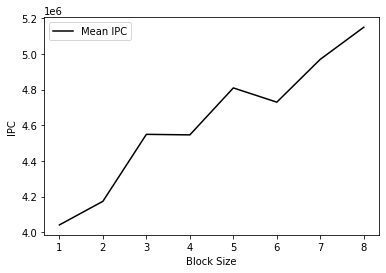

In [305]:
# Do a little manual work to get the no-ops. 

#names = ['mm-1', 'mm-2', 'mm-4', 'mm-8', 'mm-16', 'mm-32', 'mm-64', 'mm-128']
names = ['sp-01','sp-02','sp-03','sp-04','sp-05','sp-06','sp-07','sp-08',]
noops = {}
instrs = {}
cycles = {}
ipc_nonoop = {}
ipc_yesnoop = {}
ins = {}
ipc_full = {}
hit_rate = {}
hits = {}
misses = {}
#directory = 'experiment-results/Jul-14-2/stats/'
directory = 'stats/'
for name in names:
    filename = directory + f'two-level-stats-{name}.csv'
    df = pd.read_csv(filename, delimiter=', ', engine='python')
    hits[name] = list(df[(df['ComponentName']=='L1Cache_0') & (df['StatisticName']=='CacheHits')]['Count.u64'])[0]
    misses[name] = list(df[(df['ComponentName']=='L1Cache_0') & (df['StatisticName']=='CacheMisses')]['Count.u64'])[0]
    #hits[name] = list(df[(df['ComponentName']=='L2Cache') & (df['StatisticName']=='CacheHits')]['Count.u64'])[0]
    #misses[name] = list(df[(df['ComponentName']=='L2Cache') & (df['StatisticName']=='CacheMisses')]['Count.u64'])[0]
    hit_rate[name] = hits[name] / (hits[name] + misses[name])
    ins[name] = list(df[(df['ComponentName']=='Ariel') & (df['StatisticName']=='fp_sp_ins')]['Count.u64'])[0]
    noops[name] = list(df[(df['ComponentName']=='Ariel') & (df['StatisticName']=='no_ops')]['Count.u64'])[0]
    instrs[name] = list(df[(df['ComponentName']=='Ariel') & (df['StatisticName']=='instruction_count')]['Count.u64'])[0]
    cycles[name] = list(df[(df['ComponentName']=='Ariel') & (df['StatisticName']=='cycles')]['Count.u64'])[0]
    ipc_nonoop[name] = (instrs[name]-noops[name]) / cycles[name]
    ipc_yesnoop[name] = (instrs[name]/cycles[name])
    ipc_full[name] = 1/(cycles[name]/(ins[name]+instrs[name]-noops[name]))
 
ipc = cycles
sizes = sorted([int(name.split('-')[1]) for name in names])
#vals = [ipc[f'mm-{s}'] for s in sizes]
vals = [ipc[n] for n in sorted(names)]

fig, ax = plt.subplots()
ax.plot(vals, color='black', label='Mean IPC')

ax.set_ylabel('IPC')
ax.set_xlabel('Block Size')

ax.legend()
ax.set_xticks(range(len(sizes)))
ax.set_xticklabels(sizes)

plt.show()

In [463]:
# Cache size is in KiB, represents L1 cache size

cols = ['ComponentName', 'StatisticName', 'Count.u64', 'idx', 'nthreads', 'cache_size', 'type', 'size']

dtypes = np.dtype(
    [
        ("ComponentName", str),
        ("StatisticName", str),
        ("Count.u64", int),
        ("idx", int),
        ("nthreads", int),
        ("cache_size", int),
        ("type", str),
        ("size", int)
    ]
)

def get_names_and_sizes_matmul(directory):
    files = os.listdir(directory)
    names = [f.replace('two-level-stats-','').replace('.csv','') for f in files]
    sizes = [int(n.replace('mm-','')) for n in names]
    return names, sizes    

def matmul_dir_to_df(directories, nthreads, cache_size, run_type):
    dfs = pd.DataFrame(np.empty(0, dtype=dtypes))
    for idx, d in enumerate(directories):
        names, sizes = get_names_and_sizes_matmul(d)
        for name, size in zip(names, sizes):
            filename = d + f'/two-level-stats-{name}.csv'
            df = pd.read_csv(filename, delimiter=', ', engine='python')
            df['idx'] = pd.Series([idx for x in range(len(df.index))])
            df['nthreads'] = nthreads
            df['cache_size'] = cache_size
            df['type'] = run_type
            df['size'] = size
            dfs = dfs.append(df[cols])
    return dfs

# Cache size
norm_1th_2kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-3', 'Jul-16-4', 'Jul-16-5']]
mf_1th_2kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-6', 'Jul-16-7', 'Jul-16-8']]
norm_1th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-9', 'Jul-16-10', 'Jul-16-11']]
mf_1th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-12', 'Jul-16-13', 'Jul-16-14']]
norm_1th_8kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-15', 'Jul-16-16', 'Jul-16-17']]
mf_1th_8kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-16-18', 'Jul-16-19', 'Jul-16-20']]

# Multi-threaded
norm_2th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-0', 'Jul-17-1', 'Jul-17-2']]
mf_2th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-3', 'Jul-17-4', 'Jul-17-5']]
norm_4th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-6', 'Jul-17-7', 'Jul-17-8']]
mf_4th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-9', 'Jul-17-10', 'Jul-17-11']]
norm_8th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-12', 'Jul-17-13', 'Jul-17-14']]
mf_8th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in ['Jul-17-15']]# 'Jul-17-16', 'Jul-17-17']]

mm_data = pd.concat([
    matmul_dir_to_df(norm_1th_2kib, 1, 2, 'norm'),
    matmul_dir_to_df(mf_1th_2kib,   1, 2, 'mf'),
    matmul_dir_to_df(norm_1th_4kib, 1, 4, 'norm'),
    matmul_dir_to_df(mf_1th_4kib,   1, 4, 'mf'),
    matmul_dir_to_df(norm_1th_8kib, 1, 8, 'norm'),
    matmul_dir_to_df(mf_1th_8kib,   1, 8, 'mf'),
    
    matmul_dir_to_df(norm_2th_4kib, 2, 4, 'norm'),
    matmul_dir_to_df(mf_2th_4kib,   2, 4, 'mf'),
    matmul_dir_to_df(norm_4th_4kib, 4, 4, 'norm'),
    matmul_dir_to_df(mf_4th_4kib,   4, 4, 'mf'),
    matmul_dir_to_df(norm_8th_4kib, 8, 4, 'norm'),
    matmul_dir_to_df(mf_8th_4kib,   8, 4, 'mf'),
])             

In [565]:
set(mm_data['nthreads'])

{1, 2, 4, 8}

In [465]:
def get_first_count(data, comp, stat):
    return list(data[(data['ComponentName']==comp) & (data['StatisticName']==stat)]['Count.u64'])[0]
def get_mean(data, comp, stat):
    return data[(data['ComponentName']==comp) & (data['StatisticName']==stat)]['Count.u64'].mean()

def ipc_by_size_1th(data, nt, cs, **kwargs):
    #fig, ax = plt.subplots()
    
    data    = data[data['nthreads']==nt]
    
    # Just do one run for now
    #data = data[data['idx'] == 0]
    
    # Just do one cache size for now...
    data    = data[data['cache_size']==cs]
    
    data_norm = data[data['type']=='norm']
    data_mf   = data[data['type']=='mf']
    
    sizes = sorted(np.unique(data['size']))
    ipc_norm = []
    for s in sizes:
        data_tmp = data_norm[data_norm['size'] == s]
        fp_ins  = get_mean(data_tmp, 'Ariel', 'fp_sp_ins')
        mem_ins = get_mean(data_tmp, 'Ariel', 'instruction_count')
        noops   = get_mean(data_tmp, 'Ariel', 'no_ops')
        cycles  = get_mean(data_tmp, 'Ariel', 'cycles')
        #ipc_norm.append((fp_ins + mem_ins) / cycles)
        ipc_norm.append(mem_ins/cycles)
      
    ipc_mf = []
    for s in sizes:
        data_tmp = data_mf[data_mf['size'] == s]
        fp_ins  = get_mean(data_tmp, 'Ariel', 'fp_sp_ins')
        dp_ins  = get_mean(data_tmp, 'Ariel', 'fp_dp_ins')
        mem_ins = get_mean(data_tmp, 'Ariel', 'instruction_count')
        noops   = get_mean(data_tmp, 'Ariel', 'no_ops')
        cycles  = get_mean(data_tmp, 'Ariel', 'cycles')
        #ipc_mf.append((fp_ins + mem_ins) / cycles)
        ipc_mf.append((mem_ins+fp_ins+dp_ins)/cycles)
    
    
    if (len(ipc_norm) < 1):
        return
    
    print(f'----- nthreads: {nt}, cache_size: {cs} -----')
    
    print(ipc_norm)
    print(ipc_mf)
    
    fig, ax = plt.subplots()
    
    if ('spatter' in kwargs and kwargs['spatter']):
        ax.plot(sizes, ipc_norm, label='Normal')
        ax.plot(sizes, ipc_mf, label='MF')
        ax.set_xlabel('Stride', fontsize=15)
        ax.set_ylabel('IPC', fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

    else:
        ax.plot(ipc_norm, label='Normal')
        ax.plot(ipc_mf, label='MF')
        
    ax.legend(fontsize=15)
    plt.tight_layout()
    
    if 'filename' in kwargs and kwargs['filename'] is not None:
        plt.savefig(kwargs['filename'])
    
    plt.show()

    #print(df_norm)
    
    #print(df_norm[(df_norm['ComponentName']=='Ariel') & (df_norm['StatisticName']=='cycles')])
    

----- nthreads: 8, cache_size: 4 -----
[0.5867333675680008, 0.4307031827807303, 0.38008051410721894, 0.3579252453238887, 0.34540478544245334, 0.31549085380981706, 0.27761811388569557, 0.15460609225878852]
[0.5884147892682958, 0.43296072365921445, 0.3537149895742998, 0.3461947651171437, 0.33713248343023383, 0.31618357382367146, 0.27243435294868706, 0.15194646553892932]


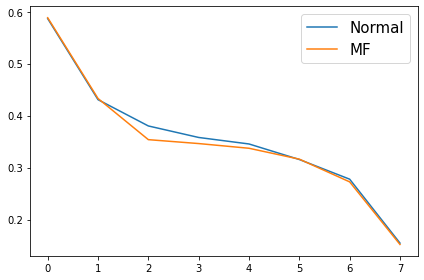

----- nthreads: 1, cache_size: 8 -----
[0.8381054434287756, 0.8229964431265956, 0.8205196964103939, 0.8419046835047603, 0.8427165501876643, 0.8444273502218803, 0.8496966503272663, 0.8535864237383952]
[0.8935051112034355, 0.9340093386801868, 0.9003353580067072, 0.9155205849770784, 0.8671723906767812, 0.9412669721586727, 0.8496331769926635, 0.9659334126520015]


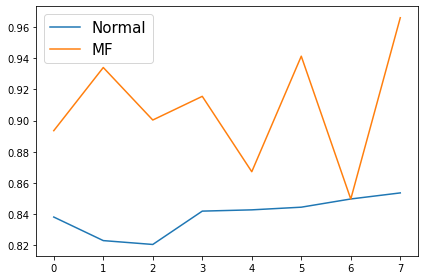

----- nthreads: 1, cache_size: 2 -----
[0.8886622511065783, 0.8924626578492532, 0.8931754845301764, 0.8891236711158067, 0.8910045911534251, 0.8952958245725832, 0.894146297882926, 0.8951665779033315]
[0.9093010381860208, 1.0220059737734528, 0.9080209981604199, 0.8715209107637515, 0.8877025977540519, 0.9051583314365, 0.852264463711956, 0.995713233247598]


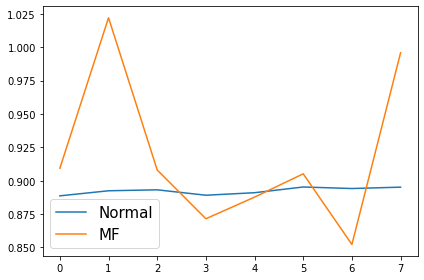

----- nthreads: 1, cache_size: 4 -----
[0.8823116443128997, 0.8816421709661767, 0.884255564351778, 0.8818607776372156, 0.8835183910037011, 0.8877982177559643, 0.8821303909759411, 0.8807779376155588]
[0.9325993986519879, 0.9256595718465249, 0.8962080712574947, 0.8792941842525503, 0.9430167588603352, 0.9101802848702724, 0.965499032643314, 0.8885099511035325]


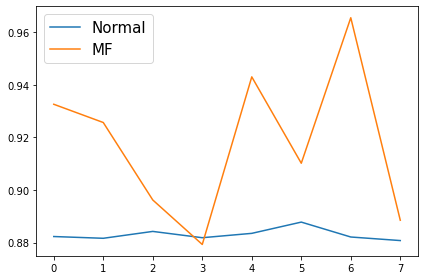

----- nthreads: 2, cache_size: 4 -----
[0.9336203686724074, 0.9340157020136474, 0.9334002453346716, 0.9049200847650685, 0.8739298874785978, 0.857703647154073, 0.8505359803440529, 0.48636881639404295]
[0.9984471133022756, 1.0452991209059823, 1.0810254049538415, 0.996497649929953, 0.970623566079138, 0.9343916886878337, 0.945368382240701, 0.5033499100669983]


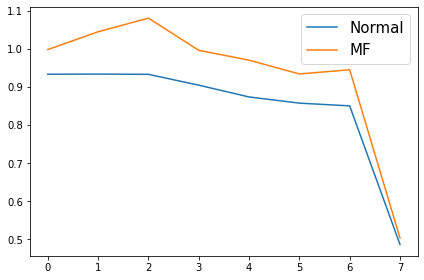

----- nthreads: 4, cache_size: 4 -----
[0.9415490454976476, 0.7384367581020684, 0.6281384625627693, 0.5790743349148201, 0.5557549927817665, 0.5450959109019182, 0.46948979272312924, 0.2661563553231271]
[0.9416586454998396, 0.7411261714891901, 0.6307605826152116, 0.5766100831988683, 0.5533193593997204, 0.537800812422683, 0.46600076598668194, 0.255092100101842]


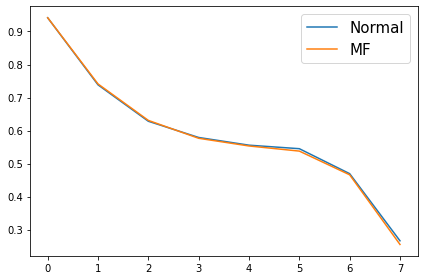

In [466]:
configs = [(nt, cs) for nt in set(mm_data['nthreads']) for cs in set(mm_data['cache_size'])]

for con in configs:
    ipc_by_size_1th(mm_data, con[0], con[1])

In [597]:
def ipc_by_size_1th_ax(data, nt, cs, ax, speedup, error, **kwargs):
    #fig, ax = plt.subplots()
    
    data    = data[data['nthreads']==nt]
    
    # Just do one run for now
    #data = data[data['idx'] == 0]
    
    # Just do one cache size for now...
    data    = data[data['cache_size']==cs]
    
    data_norm = data[data['type']=='norm']
    data_mf   = data[data['type']=='mf']
    
    sizes = sorted(np.unique(data['size']))
    ipc_norm = []
    for s in sizes:
        data_tmp = data_norm[data_norm['size'] == s]
        fp_ins  = get_mean(data_tmp, 'Ariel', 'fp_sp_ins')
        mem_ins = get_mean(data_tmp, 'Ariel', 'instruction_count')
        noops   = get_mean(data_tmp, 'Ariel', 'no_ops')
        cycles  = get_mean(data_tmp, 'Ariel', 'cycles')
        #ipc_norm.append((fp_ins + mem_ins) / cycles)
        ipc_norm.append(mem_ins/cycles)
      
    ipc_mf = []
    for s in sizes:
        data_tmp = data_mf[data_mf['size'] == s]
        fp_ins  = get_mean(data_tmp, 'Ariel', 'fp_sp_ins')
        dp_ins  = get_mean(data_tmp, 'Ariel', 'fp_dp_ins')
        mem_ins = get_mean(data_tmp, 'Ariel', 'instruction_count')
        noops   = get_mean(data_tmp, 'Ariel', 'no_ops')
        cycles  = get_mean(data_tmp, 'Ariel', 'cycles')
        #ipc_mf.append((fp_ins + mem_ins) / cycles)
        ipc_mf.append((mem_ins+fp_ins+dp_ins)/cycles)
    
    
    if (len(ipc_norm) < 1):
        return
    
    print(f'----- nthreads: {nt}, cache_size: {cs} -----')
    
    print(ipc_norm)
    print(ipc_mf)
    
    #fig, ax = plt.subplots()
    
    if ('spatter' in kwargs and kwargs['spatter']):
        ax.plot(sizes, ipc_norm, label='Normal')
        ax.plot(sizes, ipc_mf, label='MF')
        ax.set_xlabel('Stride', fontsize=15)
        ax.set_ylabel('IPC', fontsize=15)
        plt.yticks(fontsize=15)
        plt.xticks(fontsize=15)

    else:
        ax.plot([1, 2, 3, 4, 5, 6, 7, 8], ipc_norm, label='Normal')
        ax.plot([1, 2, 3, 4, 5, 6, 7, 8], ipc_mf, label='MF')
        ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8])
        ax.set_xticklabels(sizes)
        if (nt, cs) in [(8, 4)]:
            ax.set_xlabel('Block size')
            ax.set_ylabel('IPC')
        ax.set_title(f'Cores: {nt}, Cache size(KiB): {cs}')
        ax.set_ylim((0, 1.2))
        ax.text(4.5, 0.1, f'MAPE: {error}, Mean speedup: {speedup}', va='center', ha='center', fontsize=12)
        
    #ax.legend(fontsize=15)
    #plt.tight_layout()
    
    #if 'filename' in kwargs and kwargs['filename'] is not None:
    #    plt.savefig(kwargs['filename'])
    
    #plt.show()
    


----- nthreads: 1, cache_size: 2 -----
[0.8886622511065783, 0.8924626578492532, 0.8931754845301764, 0.8891236711158067, 0.8910045911534251, 0.8952958245725832, 0.894146297882926, 0.8951665779033315]
[0.9093010381860208, 1.0220059737734528, 0.9080209981604199, 0.8715209107637515, 0.8877025977540519, 0.9051583314365, 0.852264463711956, 0.995713233247598]
----- nthreads: 1, cache_size: 4 -----
[0.8823116443128997, 0.8816421709661767, 0.884255564351778, 0.8818607776372156, 0.8835183910037011, 0.8877982177559643, 0.8821303909759411, 0.8807779376155588]
[0.9325993986519879, 0.9256595718465249, 0.8962080712574947, 0.8792941842525503, 0.9430167588603352, 0.9101802848702724, 0.965499032643314, 0.8885099511035325]
----- nthreads: 1, cache_size: 8 -----
[0.8381054434287756, 0.8229964431265956, 0.8205196964103939, 0.8419046835047603, 0.8427165501876643, 0.8444273502218803, 0.8496966503272663, 0.8535864237383952]
[0.8935051112034355, 0.9340093386801868, 0.9003353580067072, 0.9155205849770784, 0.867

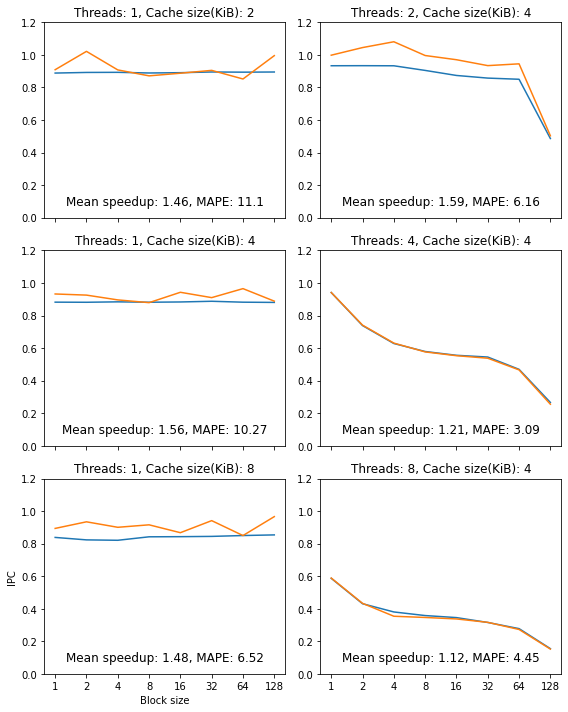

In [590]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(8,10))

ipc_by_size_1th_ax(mm_data, 1, 2, ax[0][0], 1.46, 11.10)
ipc_by_size_1th_ax(mm_data, 1, 4, ax[1][0], 1.56, 10.27)
ipc_by_size_1th_ax(mm_data, 1, 8, ax[2][0], 1.48, 6.52)

ipc_by_size_1th_ax(mm_data, 2, 4, ax[0][1], 1.59, 6.16)
ipc_by_size_1th_ax(mm_data, 4, 4, ax[1][1], 1.21, 3.09)
ipc_by_size_1th_ax(mm_data, 8, 4, ax[2][1], 1.12, 4.45)


plt.tight_layout()
plt.savefig('dissertation-figures/matmul-all.pdf')

----- nthreads: 1, cache_size: 4 -----
[0.8823116443128997, 0.8816421709661767, 0.884255564351778, 0.8818607776372156, 0.8835183910037011, 0.8877982177559643, 0.8821303909759411, 0.8807779376155588]
[0.9325993986519879, 0.9256595718465249, 0.8962080712574947, 0.8792941842525503, 0.9430167588603352, 0.9101802848702724, 0.965499032643314, 0.8885099511035325]
----- nthreads: 2, cache_size: 4 -----
[0.9336203686724074, 0.9340157020136474, 0.9334002453346716, 0.9049200847650685, 0.8739298874785978, 0.857703647154073, 0.8505359803440529, 0.48636881639404295]
[0.9984471133022756, 1.0452991209059823, 1.0810254049538415, 0.996497649929953, 0.970623566079138, 0.9343916886878337, 0.945368382240701, 0.5033499100669983]
----- nthreads: 4, cache_size: 4 -----
[0.9415490454976476, 0.7384367581020684, 0.6281384625627693, 0.5790743349148201, 0.5557549927817665, 0.5450959109019182, 0.46948979272312924, 0.2661563553231271]
[0.9416586454998396, 0.7411261714891901, 0.6307605826152116, 0.5766100831988683, 0

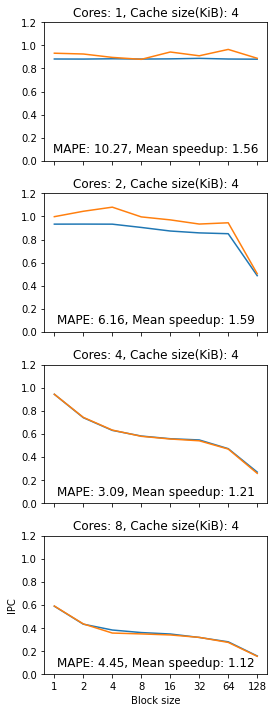

In [598]:
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(4,10))

ipc_by_size_1th_ax(mm_data, 1, 4, ax[0], 1.56, 10.27)
ipc_by_size_1th_ax(mm_data, 2, 4, ax[1], 1.59, 6.16)
ipc_by_size_1th_ax(mm_data, 4, 4, ax[2], 1.21, 3.09)
ipc_by_size_1th_ax(mm_data, 8, 4, ax[3], 1.12, 4.45)


plt.tight_layout()
plt.savefig('dissertation-figures/matmul-multithreaded.pdf')

In [500]:
def get_names_and_sizes_spatter(directory):
    files = os.listdir(directory)
    names = [f.replace('two-level-stats-','').replace('.csv','') for f in files]
    sizes = [int(n.replace('sp-','')) for n in names]
    return names, sizes    

def spatter_dir_to_df(directories, nthreads, cache_size, run_type):
    dfs = pd.DataFrame(np.empty(0, dtype=dtypes))
    for idx, d in enumerate(directories):
        names, sizes = get_names_and_sizes_spatter(d)
        for name, size in zip(names, sizes):
            filename = d + f'/two-level-stats-{name}.csv'
            df = pd.read_csv(filename, delimiter=', ', engine='python')
            df['idx'] = pd.Series([idx for x in range(len(df.index))])
            df['nthreads'] = nthreads
            df['cache_size'] = cache_size
            df['type'] = run_type
            df['size'] = size
            dfs = dfs.append(df[cols])
    return dfs

sp_norm_1th_4kib = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in [f'Jul-18-{n}' for n in range(5,15)]]
sp_mf_1th_4kib   = [f'/net/netscratch/plavin3/experiment-results/{ex}/stats' for ex in [*[f'Jul-18-{n}' for n in range(15,20)], *[f'Jul-19-{n}' for n in range(0,5)]]]

spatter_data = pd.concat([
    spatter_dir_to_df(sp_norm_1th_4kib, 1, 4, 'norm'),
    spatter_dir_to_df(sp_mf_1th_4kib,   1, 4, 'mf'),
])

#print(spatter_data)

#ipc_by_size_1th(spatter_data, spatter=True, filename='plots/spatter-trend.pdf')
ipc_by_size_1th(spatter_data, spatter=True, filename='plots/spatter-trend.pdf')

TypeError: ipc_by_size_1th() missing 2 required positional arguments: 'nt' and 'cs'

In [281]:
print(matmul_dir_to_df(norm_1th_2kib, 1, 2, 'norm'))
print(matmul_dir_to_df(mf_1th_2kib,   1, 2, 'mf'))

   ComponentName        StatisticName  Count.u64  idx  nthreads  cache_size  \
0          Ariel               no_ops     103673    0         1           2   
1          Ariel    instruction_count     216638    0         1           2   
2          Ariel               cycles    2019207    0         1           2   
3          Ariel            fp_sp_ins      39150    0         1           2   
4          Ariel            fp_dp_ins          0    0         1           2   
..           ...                  ...        ...  ...       ...         ...   
16     Parrot_l1              Latency          0    2         1           2   
17     Parrot_l1         num_requests     111199    2         1           2   
18     Parrot_l1        num_responses     111195    2         1           2   
19     Parrot_l1  num_normal_requests     111199    2         1           2   
20     Parrot_l1      num_mf_requests          0    2         1           2   

    type  size  
0   norm     1  
1   norm     1  


In [ ]:
# IPC Chart
# We expect the IPC to be highest (best) for the block size that is roughly sqrt(4096/3)

print(f'Expected best block size: {np.sqrt(4096/3):.2f}')

# Ok, let's plot the IPC for each run. 

norm[0].st['mm-15'].IPC.mean
def get_ipc(df):
    return df.IPC.mean
def get_error(df):
    return df.IPC.sd

names = set([n for n in norm[0].st])

ipc = {}
error = {}
for n in names:
    _ipc = []
    for i in range(len(norm)):
        _ipc.append(get_ipc(norm[i].st[n]))
    ipc[n] = np.mean(_ipc)
    error[n] = np.std(_ipc)

#ipc = ipc_nonoop
#ipc = ipc_full
sizes = sorted([int(name.split('-')[1]) for name in names])
vals = [ipc[f'mm-{s}'] for s in sizes]
sdup = [ipc[f'mm-{s}'] + error[f'mm-{s}'] for s in sizes]
sddown = [ipc[f'mm-{s}'] - error[f'mm-{s}'] for s in sizes]
#print(sizes)
#print(vals)

fig, ax = plt.subplots()
ax.plot(vals, color='black', label='Mean IPC')
#if (len(norm) > 1):
#    ax.plot(sdup, color='orange', label='1 SD')
#    ax.plot(sddown, color='orange')

ax.set_ylabel('IPC')
ax.set_xlabel('Block Size')

ax.legend()
ax.set_xticks(range(len(sizes)))
ax.set_xticklabels(sizes)

plt.show()

In [71]:
norm[0].st['mm-1']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1181.832   
1            memHierarchy.Bus   59892062             58.351   
2          memHierarchy.Cache  262149953           1721.417   
3  memHierarchy.MemController   49999999            117.985   
4         memHierarchy.Parrot  144576554            313.618   

    avg. handler time (ns)  
0                     5909  
1                      974  
2                     6566  
3                     2359  
4                     2169  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus     11350443           2.469                   217
1  memHierarchy.MemLink    196388315        1120.856                  5707
2   memHierarchy.Parrot    185023687         169.201                   914
Simulated time:
  100.00 (+/-0.00) ms (sem 0.00)
Wallclock Time:
  Real: 4790590.00 (+/-0.00) ms (sem 0.0

In [109]:
aggregate = fun1(mf[1].st)
print(aggregate)
# Drop a few columns for now
#dropped = aggregate[['benchmark', 'time(ariel)', 'time(memH)', 'MPS']]
#print(dropped.to_latex(float_format="%.2f", index=False))

((aggregate['time(ariel)'] + aggregate['time(memH)'] + aggregate['time(Parrot)'])/(aggregate['time(ariel)'] + aggregate['time(memH)'])).mean()

         benchmark  time(ariel)   time(memH)  time(Parrot)       MPS     A-MPS
0              2mm  1959.236524  1154.738138    399.340353  1.589382  1.320277
1              3mm  2142.804014  3424.887911    455.824806  2.598321  2.142550
2              adi  1471.288464  2163.722926    299.075997  2.470631  2.053256
3             atax    80.104645   116.180745     16.852090  2.450362  2.024464
4             bicg    72.841157   100.988606     15.316239  2.386422  1.971811
5         cholesky  1247.195742  1724.424299    269.481822  2.382641  1.959296
6      correlation  1419.860170   210.373217    237.676742  1.148165  0.983528
7       covariance  1419.719232   250.572016    237.298197  1.176494  1.008011
8          deriche   775.540047  1168.601397    177.256356  2.506823  2.040458
9          doitgen  1519.102260   253.331000    263.266329  1.166764  0.994426
10          durbin    38.165963    57.931460      9.444699  2.517883  2.018401
11         fdtd-2d  1645.812052  2184.580451    327.

1.108288569765201

NameError: name 'y_norm_ipc' is not defined

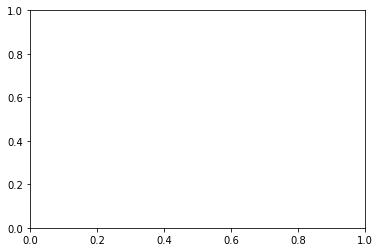

In [164]:
x = np.arange(len(names))
width = 0.25
fig, ax = plt.subplots()
ax.bar(x-width/2, y_norm_ipc, width, color='lightgrey', label='Normal', edgecolor='black')
ax.bar(x+width/2, y_mf_ipc, width, color='black', label='Multidelity', edgecolor='black')
#ax.bar(x+width, y_mfn_ipc, width, color='lightblue', label='Multidelity New', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(names, rotation=45, ha='right')
ax.set_ylim((0,2))
ax.set_ylabel('IPC', rotation=90)
ax.set_title('IPC (Normal vs. Multifidelity)')
ax.autoscale()
plt.legend()

#ax.yaxis.set_label_coords(-.07, 0.96)
nyticks = 11
ax.set_yticks([(2/(nyticks-1))*x for x in np.arange(nyticks)])
fig.set_size_inches((15,3))
fig.savefig('plots/ipc-normal-vs-mf.png')
#plt.tight_layout()

In [10]:
pct_err = []

def p_err(approx, exact):
    return (approx-exact)/exact * 100
def mape(arr):
    return np.mean(np.absolute(arr))

print('Percent error\n')
name_len = max([len(name) for name in names])
for (i, name) in enumerate(names):
    pe = p_err(y_mf_ipc[i], y_norm_ipc[i])
    pct_err.append(pe)
    print(f'{i}'.ljust(2), f'{name}'.ljust(name_len), f'{pe: 06.2f}%')
    
print(f'\nMAPE: {mape(pct_err):.2f}%')

Percent error

0  jacobi-1d      -02.00%
1  trisolv         00.39%
2  gesummv        -01.03%
3  durbin          00.08%
4  bicg           -02.34%
5  atax           -01.53%
6  mvt             00.31%
7  gemver         -01.20%
8  trmm            02.46%
9  seidel-2d       03.12%
10 deriche         00.34%
11 symm            04.07%
12 covariance      01.50%
13 correlation     06.51%
14 gramschmidt     05.03%
15 syr2k           00.93%
16 heat-3d         03.17%
17 doitgen         01.23%
18 gemm            02.70%
19 jacobi-2d       01.27%
20 2mm            -01.46%
21 cholesky       -06.05%
22 lu             -08.84%
23 fdtd-2d        -08.01%
24 adi            -01.80%
25 ludcmp          00.41%
26 syrk           -02.58%
27 floyd-warshall -03.75%
28 3mm            -01.41%
29 nussinov        03.48%

MAPE: 2.63%


In [11]:
# Speed up calculations
mf_times_seconds = []
norm_times_seconds = []
for name in names:
    mf_times_seconds.append(mf.st[name].times.real.mean/nu.s)
    norm_times_seconds.append(norm.st[name].times.real.mean/nu.s)

speedup = [((norm_times_seconds[i] / mf_times_seconds[i])) for i in range(len(names))]

print('Speedup\n')
for i in range(len(names)):
    print(f'{i}'.ljust(2), f'{names[i]}'.ljust(name_len), f'{speedup[i]: 7.2f}')

print(f'\nAverage speedup: {np.mean(speedup):.2f}')

Speedup

0  jacobi-1d         1.00
1  trisolv           1.00
2  gesummv           0.95
3  durbin            0.99
4  bicg              0.97
5  atax              0.97
6  mvt               1.00
7  gemver            0.96
8  trmm              2.49
9  seidel-2d         1.92
10 deriche           1.00
11 symm              2.30
12 covariance        2.45
13 correlation       2.35
14 gramschmidt       2.39
15 syr2k             2.05
16 heat-3d           1.29
17 doitgen           2.20
18 gemm              2.07
19 jacobi-2d         2.07
20 2mm               2.25
21 cholesky          1.03
22 lu                1.03
23 fdtd-2d           1.06
24 adi               1.01
25 ludcmp            0.96
26 syrk              0.99
27 floyd-warshall    1.21
28 3mm               0.97
29 nussinov          0.93

Average speedup: 1.46


In [46]:
# Calculate speedup of the Memory simulation (subtract off Ariel time)

def mean_ariel_time(data, name):
    return np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in data.st[name].profile])

mf_times_seconds_noariel = []
norm_times_seconds_noariel = []
for name in names:
    mf_times_seconds_noariel.append(mf.st[name].times.real.mean/nu.s - mean_ariel_time(mf,name))
    norm_times_seconds_noariel.append(norm.st[name].times.real.mean/nu.s - mean_ariel_time(norm,name))

In [14]:
ariel_time = np.mean([np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile])
ariel_time

1082.829858

In [9]:
print('Percent speedup without Ariel')
#TODO - also remove parrot time from norm runs

speedup_pct = [((norm_times_seconds_noariel[i] / mf_times_seconds_noariel[i])-1)*100 for i in range(len(names))]

for i, n in enumerate(names):
    print(f'{n.ljust(14)}: {speedup_pct[i]:6.02f}%')

Percent speedup without Ariel
jacobi-1d     :  -9.61%
trisolv       :  -6.21%
gesummv       :  -9.76%
durbin        :  -9.36%
bicg          :  -4.81%
atax          :  -2.53%
mvt           :  -6.88%
gemver        :  -5.18%
heat-3d       :  86.44%
ludcmp        : 131.90%
syr2k         : 136.67%
trmm          : 157.45%
correlation   : 150.52%
gramschmidt   : 149.37%
symm          : 126.56%
covariance    : 121.50%
doitgen       : 109.49%
gemm          : 116.09%
jacobi-2d     : 118.08%
floyd-warshall: 103.76%
2mm           : 121.12%
cholesky      :   0.58%
seidel-2d     :   2.76%
deriche       :   2.22%
lu            :   2.21%
adi           :   1.93%
fdtd-2d       :   2.89%
syrk          :   1.65%
3mm           :   3.42%
nussinov      :   2.13%


In [196]:
norm.st['deriche']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999            254.418   
1            memHierarchy.Bus   24576113             13.962   
2          memHierarchy.Cache  155077942            331.588   
3  memHierarchy.MemController   49999999            102.050   
4         memHierarchy.Parrot   78646625             68.045   

    avg. handler time (ns)  
0                     1272  
1                      568  
2                     2138  
3                     2041  
4                      865  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      4725089           0.436                    92
1  memHierarchy.MemLink    105901573         250.344                  2363
2   memHierarchy.Parrot    100380124          42.935                   427
Simulated time:
  2.37 (+/-0.16) ms
Wallclock Time:
  Real: 30206.85 (+/-476.47) ms
  User: 29819.93 (+/-

In [197]:
[np.float(x['ClockStats'][x['ClockStats']['Name']=='ariel.ariel'][' handler time (s)']) for x in mf.st['2mm'].profile]

[477.159364, 478.199233, 472.19425700000005, 458.189289, 468.041158]

In [274]:
mf.st['2mm']

Profiler: ClockStats
                         Name      count   handler time (s)  \
0                 ariel.ariel  199999999           1175.339   
1            memHierarchy.Bus    8446518             13.142   
2          memHierarchy.Cache   39507364            308.108   
3  memHierarchy.MemController   49999999            121.382   
4         memHierarchy.Parrot  145400710            315.106   

    avg. handler time (ns)  
0                     5876  
1                     1555  
2                     7798  
3                     2427  
4                     2167  
Profiler: EventStats
                   Name   recv count   recv time (s)   avg. recv time (ns)
0      memHierarchy.Bus      2162912           0.579                   267
1  memHierarchy.MemLink    108949898         651.677                  5981
2   memHierarchy.Parrot    187950003         257.391                  1369
Simulated time:
  23067.82 (+/-0.00) ms
Wallclock Time:
  Real: 676904356.15 (+/-0.00) ms
  User: 6671120